In [1]:
# import packages
import glob
from pathlib import Path
import os
import numpy as np
from datetime import datetime
from datetime import timedelta
import pandas as pd
import calendar
import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
import math
from pathos.threading import ThreadPool as Pool
from scipy.optimize import least_squares
import sklearn
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import random
import cartopy.crs as ccrs
from scipy.stats import gaussian_kde
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy import stats

In [2]:
# define your script working directory
# work_dir=Path("/mnt/u/LSM root zone/global_sr/")
# work_dir=Path('/tudelft.net/staff-umbrella/LSM root zone/global_sr')
work_dir=Path("/scratch/fransjevanoors/global_sr/")
# define your data directory
data_dir=Path(f'{work_dir}/data')

out_dir=Path(f'{work_dir}/output')

### 1. map selected catchments

/tmp/ipykernel_3055/840378724.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh['centroid'] = sh.centroid
/tmp/ipykernel_3055/840378724.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh.centroid.plot(markersize=0.7,ax=ax)


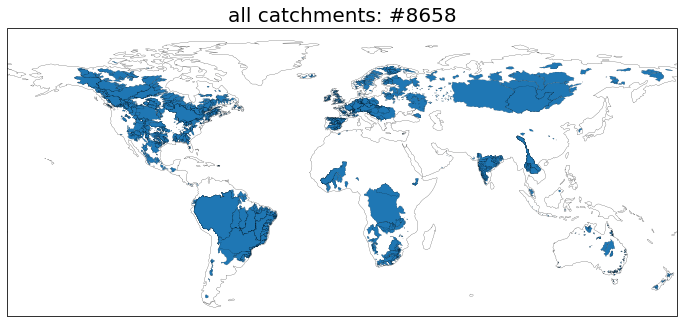

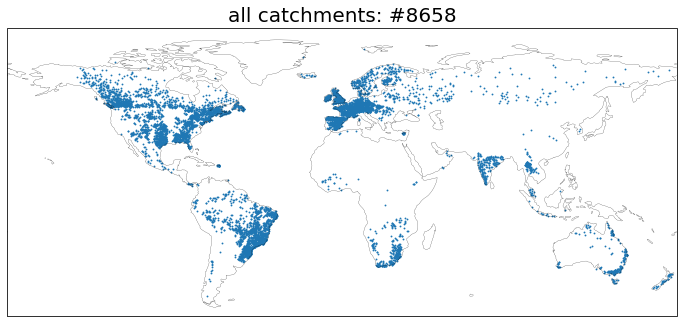

In [3]:
# map all catchments
sh = gpd.read_file(f'{out_dir}/geo_catchments.shp')
sh.index = sh.catch_id
sh['centroid'] = sh.centroid

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.2)
sh.plot(edgecolor='black',linewidth=0.1,ax=ax)
ax.set_title(f'all catchments: #{len(sh)}',size=20)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{out_dir}/figures/catchment_overview/map_allcatchments_shapes.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.2)
sh.centroid.plot(markersize=0.7,ax=ax)
ax.set_title(f'all catchments: #{len(sh)}',size=20)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{out_dir}/figures/catchment_overview/map_allcatchments_points.jpg',bbox_inches='tight',dpi=300)

/tmp/ipykernel_3055/2912706931.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh['centroid'] = sh.centroid
/tmp/ipykernel_3055/2912706931.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh.centroid.plot(markersize=0.7,ax=ax)


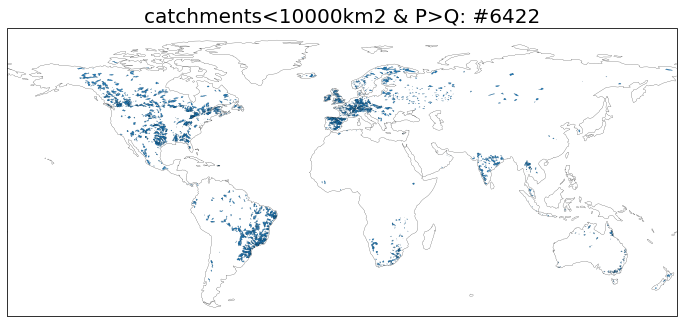

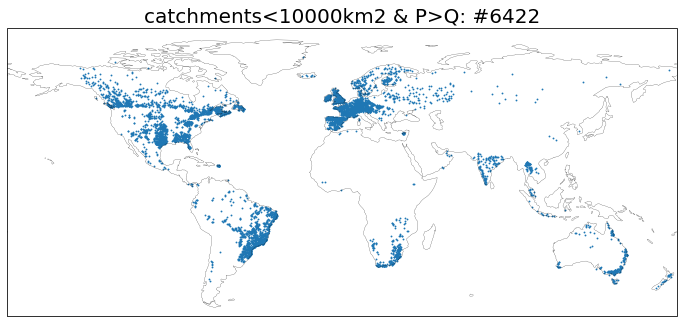

In [4]:
# map selected catchments based on area and wb
sh = gpd.read_file(f'{out_dir}/geo_catchments_sel_area_wb.shp')
sh.index = sh.catch_id
sh['centroid'] = sh.centroid

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.2)
sh.plot(edgecolor='black',linewidth=0.05,ax=ax)
ax.set_title(f'catchments<10000km2 & P>Q: #{len(sh)}',size=20)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{out_dir}/figures/catchment_overview/map_selcatchments_shapes.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.2)
sh.centroid.plot(markersize=0.7,ax=ax)
ax.set_title(f'catchments<10000km2 & P>Q: #{len(sh)}',size=20)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{out_dir}/figures/catchment_overview/map_selcatchments_points.jpg',bbox_inches='tight',dpi=300)

### 2. plot catchments in budyko

In [5]:
# load selected catchment characteristics based on area and wb
c = pd.read_csv(f'{out_dir}/catchment_characteristics_sel_area_wb.csv',index_col=0)
c.head()

,p_mean,ep_mean,q_mean,t_mean,ai,si_p,si_ep,phi,tc,ntc,nonveg,area
102101A,5.013324,3.821485,2.451285,26.111414,1.311879,0.845662,0.166897,2,23.077881,64.030838,12.891281,648.4
104001A,3.615239,3.384188,1.232168,25.894186,1.068274,1.013597,0.176452,3,17.910576,67.989027,14.100397,473.7
105101A,4.120194,3.548841,0.837701,24.468281,1.160997,0.838043,0.168695,2,19.812427,64.472516,15.715056,2308.6
105102A,3.051206,3.247410,0.742289,24.834575,0.939581,0.945253,0.169238,4,14.801930,68.073281,17.124789,1322.0
105105A,5.280687,3.848386,1.194697,24.624683,1.372182,0.805871,0.181118,0,22.074308,62.859330,15.066361,296.1


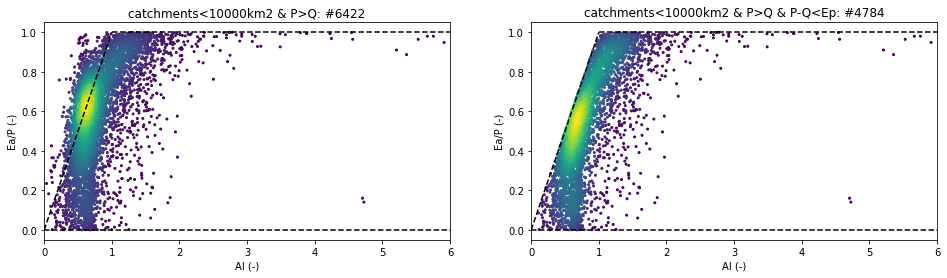

In [6]:
# plot catchments in budyko
ep = c.ep_mean
p = c.p_mean
q = c.q_mean
x = ep/p
y = (p-q)/p
x = x.dropna() # a few points with nan for AI
y = y[x.index]

# calculate point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.scatter(x,y,c=z,s=4)
ax.plot([0,1],[0,1], '--k')
ax.plot([1,12],[1,1], '--k')
ax.plot([0,12],[0,0], '--k')
ax.set_xlabel('AI (-)')
ax.set_ylabel('Ea/P (-)')
ax.set_xlim(0,6)
ax.set_ylim(-0.05,1.05)
ax.set_title(f'catchments<10000km2 & P>Q: #{len(c)}')

# plot catchments in budyko - only when Ea<Ep
cs = c[c.ep_mean>(c.p_mean-c.q_mean)]
ep = cs.ep_mean
p = cs.p_mean
q = cs.q_mean
x = ep/p
y = (p-q)/p
x = x.dropna() # a few points with nan for AI
y = y[x.index]

# calculate point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(122)
ax.scatter(x,y,c=z,s=4)
ax.plot([0,1],[0,1], '--k')
ax.plot([1,12],[1,1], '--k')
ax.plot([0,12],[0,0], '--k')
ax.set_xlabel('AI (-)')
ax.set_ylabel('Ea/P (-)')
ax.set_xlim(0,6)
ax.set_ylim(-0.05,1.05)
ax.set_title(f'catchments<10000km2 & P>Q & P-Q<Ep: #{len(cs)}')
fig.savefig(f'{out_dir}/figures/catchment_overview/budyko_selcatchments.jpg',bbox_inches='tight',dpi=300)


### 3. make histograms of catchment characteristics

In [7]:
c = pd.read_csv(f'{out_dir}/catchment_characteristics_sel_area_wb.csv',index_col=0)

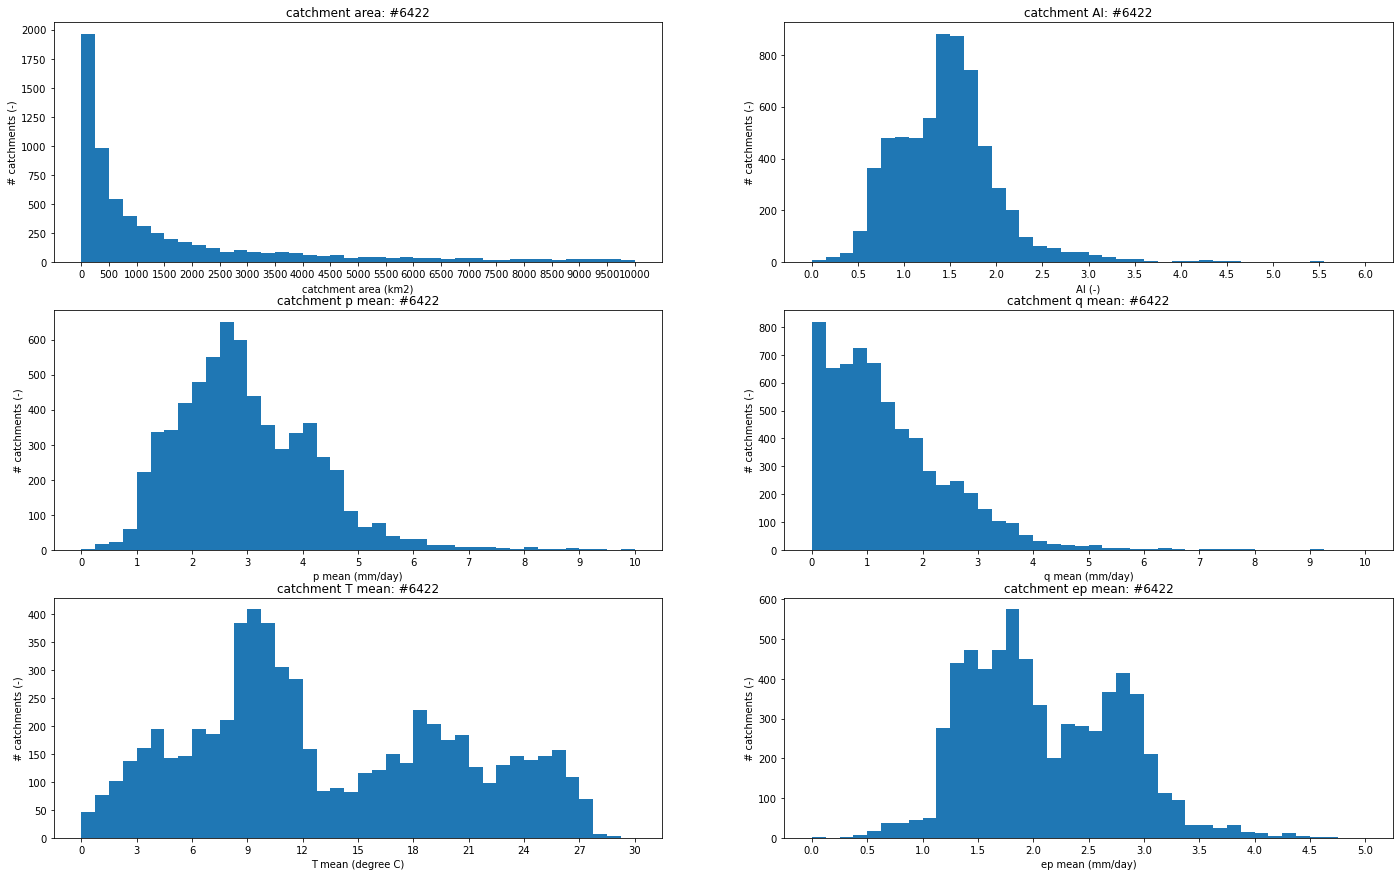

In [8]:
# area
bins = np.linspace(0,10000,41)
bins2 = np.linspace(0,10000,21)
fig = plt.figure(figsize=(24,15))
ax = fig.add_subplot(321)
ax.hist(c.area,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('catchment area (km2)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment area: #{len(c)}')

# aridity index
bins = np.linspace(0,6,41)
bins2 = np.linspace(0,6,13)
ax = fig.add_subplot(322)
ax.hist(c.ai,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('AI (-)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment AI: #{len(c)}')

# mean p
bins = np.linspace(0,10,41)
bins2 = np.linspace(0,10,11)
ax = fig.add_subplot(323)
ax.hist(c.p_mean,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('p mean (mm/day)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment p mean: #{len(c)}')

# mean q
bins = np.linspace(0,10,41)
bins2 = np.linspace(0,10,11)
ax = fig.add_subplot(324)
ax.hist(c.q_mean,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('q mean (mm/day)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment q mean: #{len(c)}')

# mean T
bins = np.linspace(0,30,41)
bins2 = np.linspace(0,30,11)
ax = fig.add_subplot(325)
ax.hist(c.t_mean,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('T mean (degree C)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment T mean: #{len(c)}')

# mean Ep
bins = np.linspace(0,5,41)
bins2 = np.linspace(0,5,11)
ax = fig.add_subplot(326)
ax.hist(c.ep_mean,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('ep mean (mm/day)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment ep mean: #{len(c)}')

fig.savefig(f'{out_dir}/figures/catchment_overview/catch_characteristics1.jpg',bbox_inches='tight',dpi=300)


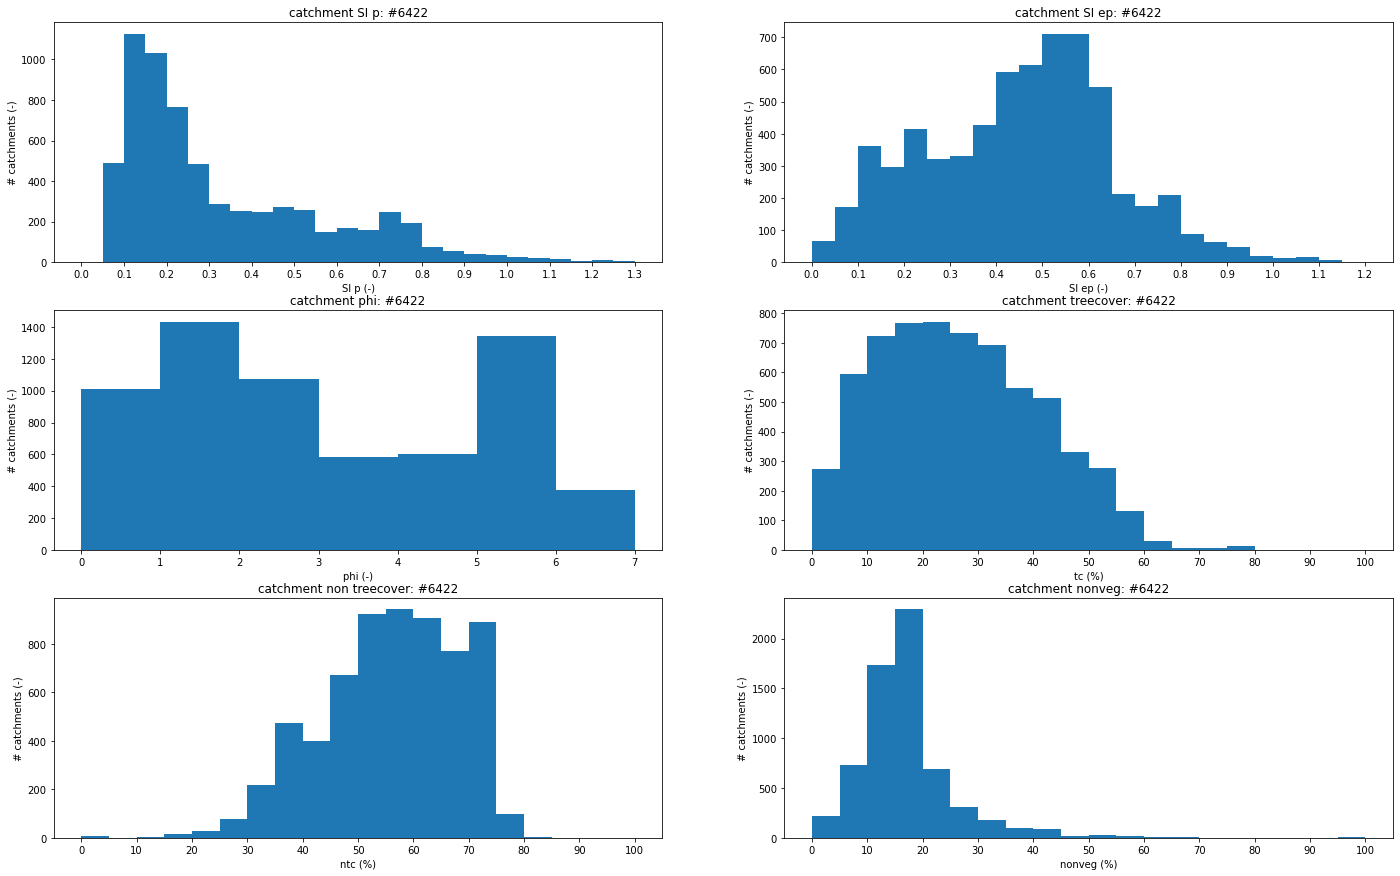

In [9]:
# si p
bins = np.linspace(0,1.3,27)
bins2 = np.linspace(0,1.3,14)
fig = plt.figure(figsize=(24,15))
ax = fig.add_subplot(321)
ax.hist(c.si_p,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('SI p (-)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment SI p: #{len(c)}')

# si ep
bins = np.linspace(0,1.2,25)
bins2 = np.linspace(0,1.2,13)
ax = fig.add_subplot(322)
ax.hist(c.si_ep,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('SI ep (-)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment SI ep: #{len(c)}')

# phi
bins = np.linspace(0,7,8)
bins2 = np.linspace(0,7,8)
ax = fig.add_subplot(323)
ax.hist(c.phi,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('phi (-)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment phi: #{len(c)}')

# tc
bins = np.linspace(0,100,21)
bins2 = np.linspace(0,100,11)
ax = fig.add_subplot(324)
ax.hist(c.tc,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('tc (%)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment treecover: #{len(c)}')

# ntc
bins = np.linspace(0,100,21)
bins2 = np.linspace(0,100,11)
ax = fig.add_subplot(325)
ax.hist(c.ntc,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('ntc (%)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment non treecover: #{len(c)}')

# nonveg
bins = np.linspace(0,100,21)
bins2 = np.linspace(0,100,11)
ax = fig.add_subplot(326)
ax.hist(c.nonveg,bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('nonveg (%)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment nonveg: #{len(c)}')

fig.savefig(f'{out_dir}/figures/catchment_overview/catch_characteristics2.jpg',bbox_inches='tight',dpi=300)


## 4. Sr mapping

In [3]:
#colors
a = 255/255
b = 220/255
c = 201/255
d = 133/255
e = 85/255
f = 70/255
g = 46/255

c1 = (e,0,0)
c2 = (c,0,0)
c3 = (a,g,0)
c4 = (a,d,0)
c5 = (a,b,0)
c6 = (a,a,f)
c7 = (f,a,a)
c8 = (0,b,a)
c9 = (0,d,a)
c10 = (0,g,a)
c11 = (0,0,c)
c12 = (0,0,e)

colors=[c12,c11,c10,c9,c8,c7,c6,c5,c4,c3,c2,c1]
cm = ListedColormap(colors)

In [4]:
#shapes
sh = gpd.read_file(f'{work_dir}/output/geo_catchments_sel_area_wb.shp')
sh.index = sh.catch_id
sh['centroid'] = sh.centroid

# sr dataframe
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)
sr_df = sr_df[sr_df['20']>20]

# match sh and sr dfs
sh_sr = sh.loc[sr_df.index]
sh_sr['sr_20'] = sr_df['20']
sh_sr = sh_sr.drop(columns=['geometry'])
sh_sr = sh_sr.rename(columns={'centroid':'geometry'})

/tmp/ipykernel_404264/3902150027.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh['centroid'] = sh.centroid


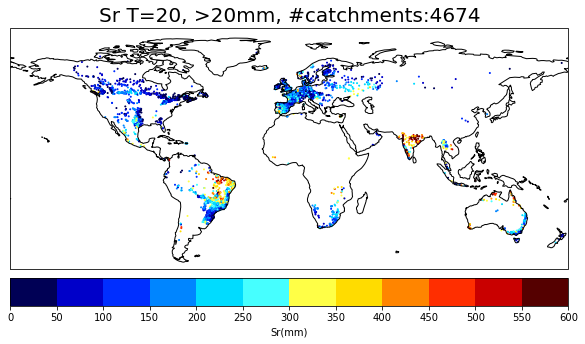

In [5]:
lvls = np.linspace(0,600,13)
fig = plt.figure(figsize=(10,8))
# cm = plt.cm.get_cmap('jet')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
pl = sh_sr.plot(column='sr_20',ax=ax, markersize=1, cmap=cm,
           k=10,vmin=0,vmax=600,
           legend=True,
           legend_kwds={'label': "Sr(mm)", 'orientation': "horizontal", 'pad':0.02,'ticks':lvls})
ax.set_title(f'Sr T=20, >20mm, #catchments:{len(sr_df)}',size=20)
fig.savefig(f'{out_dir}/figures/catchment_overview/sr_map.jpg',bbox_inches='tight',dpi=300)


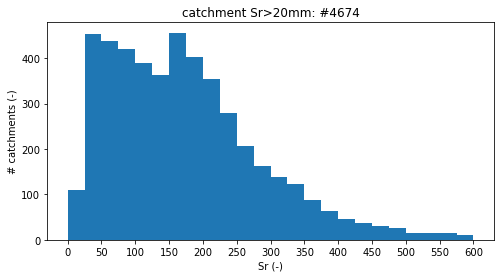

In [6]:
# sr
bins = np.linspace(0,600,25)
bins2 = np.linspace(0,600,13)
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.hist(sr_df['20'],bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('Sr (-)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment Sr>20mm: #{len(sr_df)}')
fig.savefig(f'{out_dir}/figures/catchment_overview/sr_hist.jpg',bbox_inches='tight',dpi=300)


In [7]:
sr_df['20'].max()

870.7095427446989

Text(0, 0.5, 'minmax rz year')

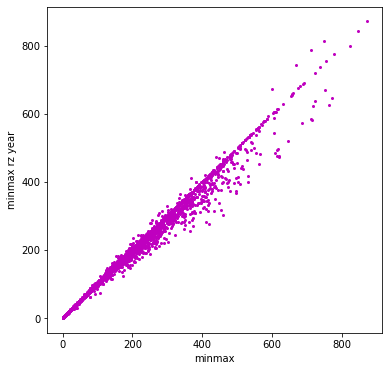

In [8]:
# plt sr minmax vd dt minmax rootzone year
sr1_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments_maxmin.csv',index_col=0)
sr2_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(sr1_df['20'],sr2_df['20'],'mo',markersize=2)
ax.set_xlabel('minmax')
ax.set_ylabel('minmax rz year')

### 5. Budyko

In [9]:
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)
sr = sr_df['20']

In [67]:
# sample catchments with low sr
srl = sr[sr<200]
srh = sr[sr>200]
srl_ix = srl.sample(100).index
srl = sr.loc[srl_ix]
sr = pd.concat([srl,srh]) #concat subsample of sr<200 with all sr>200

In [70]:
c = pd.read_csv(f'{out_dir}/catchment_characteristics_sel_area_wb.csv',index_col=0)
c = c.loc[sr.index]
tc = c.tc
ntc = c.ntc
lat = c.lat
ep = c.ep_mean
p = c.p_mean
q = c.q_mean
si_p = c.si_p
phi = c.phi
x = ep/p
y = (p-q)/p
x = x.dropna() # a few points with nan for AI
y = y[x.index]
tc = tc[x.index]
ntc = ntc[x.index]
lat = lat[x.index]

Text(0.5, 1.0, 'color by sr')

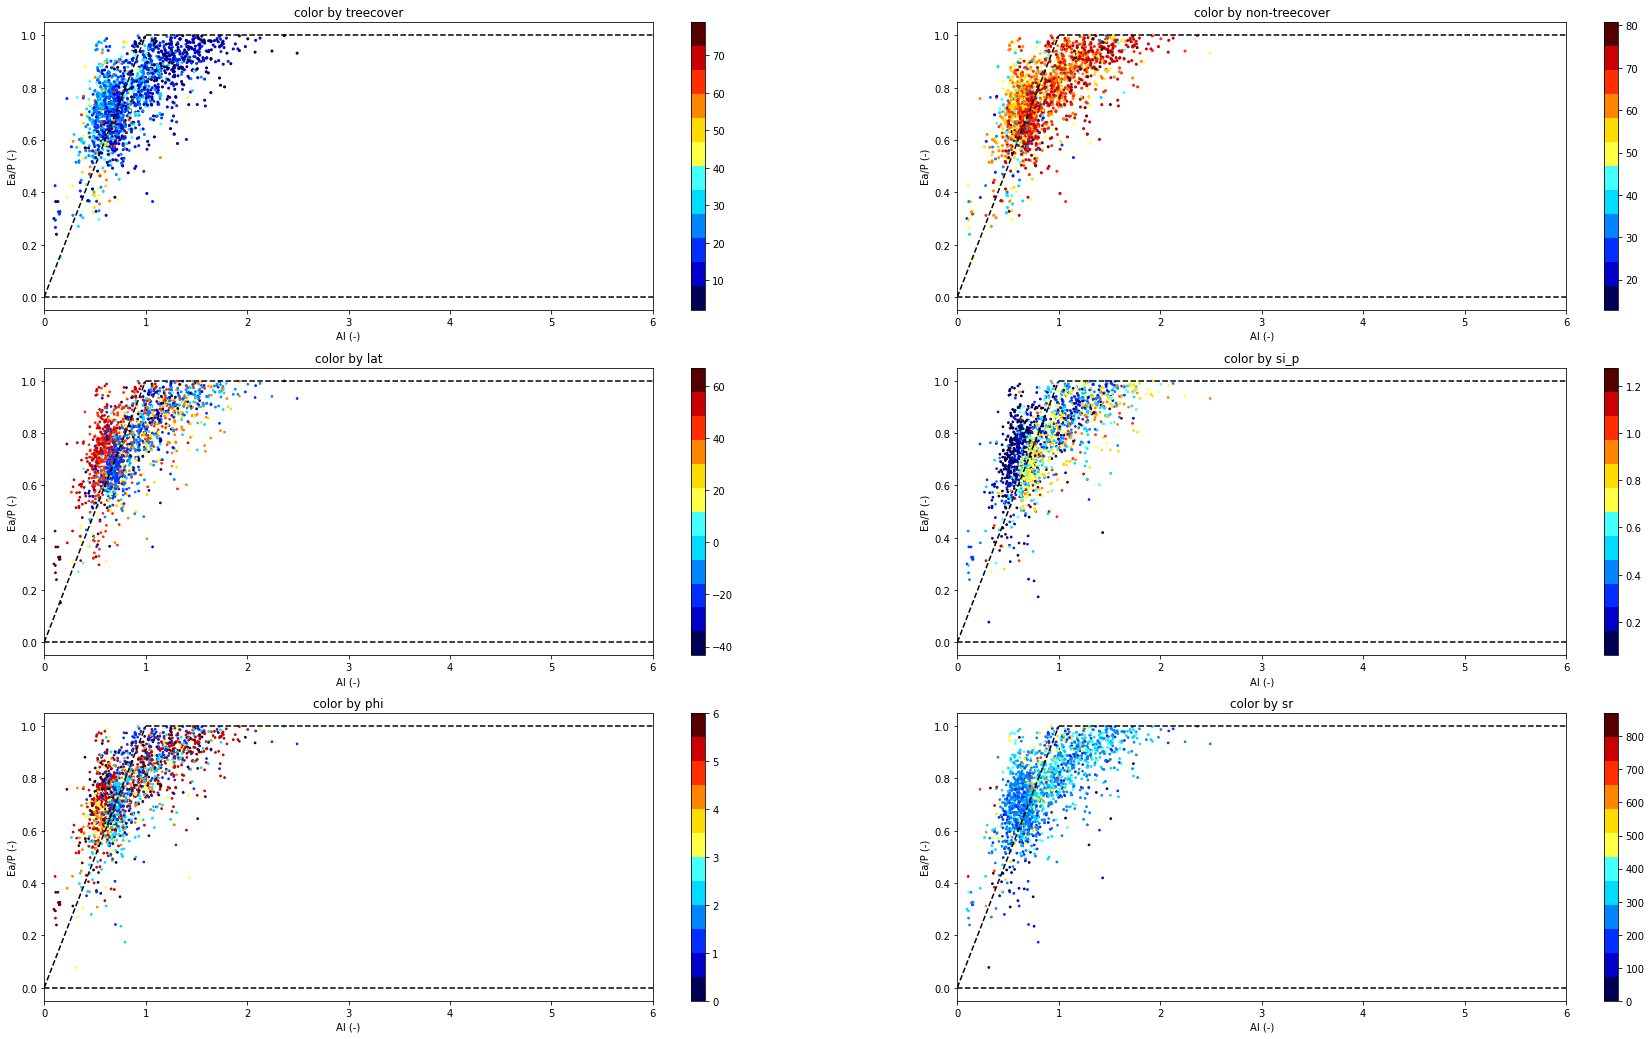

In [71]:
fig = plt.figure(figsize=(30,18))
ax = fig.add_subplot(321)
f = ax.scatter(x,y,c=tc,s=4,cmap=cm)
plt.colorbar(f)
ax.plot([0,1],[0,1], '--k')
ax.plot([1,12],[1,1], '--k')
ax.plot([0,12],[0,0], '--k')
ax.set_xlabel('AI (-)')
ax.set_ylabel('Ea/P (-)')
ax.set_xlim(0,6)
ax.set_ylim(-0.05,1.05)
ax.set_title(f'color by treecover')

ax = fig.add_subplot(322)
f = ax.scatter(x,y,c=ntc,s=4,cmap=cm)
plt.colorbar(f)
ax.plot([0,1],[0,1], '--k')
ax.plot([1,12],[1,1], '--k')
ax.plot([0,12],[0,0], '--k')
ax.set_xlabel('AI (-)')
ax.set_ylabel('Ea/P (-)')
ax.set_xlim(0,6)
ax.set_ylim(-0.05,1.05)
ax.set_title(f'color by non-treecover')

ax = fig.add_subplot(323)
f = ax.scatter(x,y,c=lat,s=3,cmap=cm)
plt.colorbar(f)
ax.plot([0,1],[0,1], '--k')
ax.plot([1,12],[1,1], '--k')
ax.plot([0,12],[0,0], '--k')
ax.set_xlabel('AI (-)')
ax.set_ylabel('Ea/P (-)')
ax.set_xlim(0,6)
ax.set_ylim(-0.05,1.05)
ax.set_title(f'color by lat')

ax = fig.add_subplot(324)
f = ax.scatter(x2,y2,c=si_p,s=3,cmap=cm)
plt.colorbar(f)
ax.plot([0,1],[0,1], '--k')
ax.plot([1,12],[1,1], '--k')
ax.plot([0,12],[0,0], '--k')
ax.set_xlabel('AI (-)')
ax.set_ylabel('Ea/P (-)')
ax.set_xlim(0,6)
ax.set_ylim(-0.05,1.05)
ax.set_title(f'color by si_p')

ax = fig.add_subplot(325)
f = ax.scatter(x2,y2,c=phi,s=3,cmap=cm)
plt.colorbar(f)
ax.plot([0,1],[0,1], '--k')
ax.plot([1,12],[1,1], '--k')
ax.plot([0,12],[0,0], '--k')
ax.set_xlabel('AI (-)')
ax.set_ylabel('Ea/P (-)')
ax.set_xlim(0,6)
ax.set_ylim(-0.05,1.05)
ax.set_title(f'color by phi')

ax = fig.add_subplot(326)
f = ax.scatter(x2,y2,c=sr,s=3,cmap=cm)
plt.colorbar(f)
ax.plot([0,1],[0,1], '--k')
ax.plot([1,12],[1,1], '--k')
ax.plot([0,12],[0,0], '--k')
ax.set_xlabel('AI (-)')
ax.set_ylabel('Ea/P (-)')
ax.set_xlim(0,6)
ax.set_ylim(-0.05,1.05)
ax.set_title(f'color by sr')

In [18]:
c

,p_mean,ep_mean,q_mean,t_mean,ai,si_p,si_ep,phi,tc,ntc,nonveg,area,lat,lon
catch_id,,,,,,,,,,,,,,
za_0000167,2.731415,2.225398,0.926851,14.217723,1.227383,0.656479,0.326011,1,14.681650,70.861581,14.456770,1842.7500,-29.576796,29.617262
de_0000129,3.163824,1.889784,2.214790,8.689071,1.674172,0.149524,0.447508,5,34.649090,47.867156,17.483754,78.8742,48.923233,13.382440
es_0000787,0.988730,2.018325,0.083651,16.170287,0.489876,0.277440,0.470791,3,3.638195,38.284882,58.076923,169.7209,38.015789,-1.672939
br_0001831,4.406135,2.940346,1.433599,24.315706,1.498509,0.750471,0.144086,2,13.659417,70.688479,15.652104,2368.6570,-17.329335,-48.904344
es_0001076,1.649784,1.793561,0.267195,11.431009,0.919837,0.218576,0.522140,3,14.148874,54.132412,31.718714,321.4395,42.054044,-2.191177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fr_0000086,2.960251,1.917064,0.833332,9.474569,1.544159,0.203801,0.506462,3,26.890775,55.259278,17.849947,193.2453,44.592961,5.143091
ca_0001025,2.447737,1.933218,1.049551,4.543701,1.266146,0.141173,0.559184,2,59.297737,27.143360,13.558903,2693.9700,45.539664,-78.211763
br_0001145,2.744817,2.879167,0.098244,24.941000,0.953337,0.258088,0.161133,4,16.659767,67.251924,16.088308,529.0432,-12.041363,-38.728620


In [10]:
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)
sr = sr_df['20']
sr = sr[sr>20]

c = pd.read_csv(f'{out_dir}/catchment_characteristics_sel_area_wb.csv',index_col=0)
c = c.loc[sr.index]
tc = c.tc
ntc = c.ntc
lat = c.lat
ep = c.ep_mean
p = c.p_mean
q = c.q_mean
ai = c.ai
si_p = c.si_p
phi = c.phi
x = ep/p
y = (p-q)/p
x = x.dropna() # a few points with nan for AI
y = y[x.index]
tc = tc[x.index]
ntc = ntc[x.index]
lat = lat[x.index]

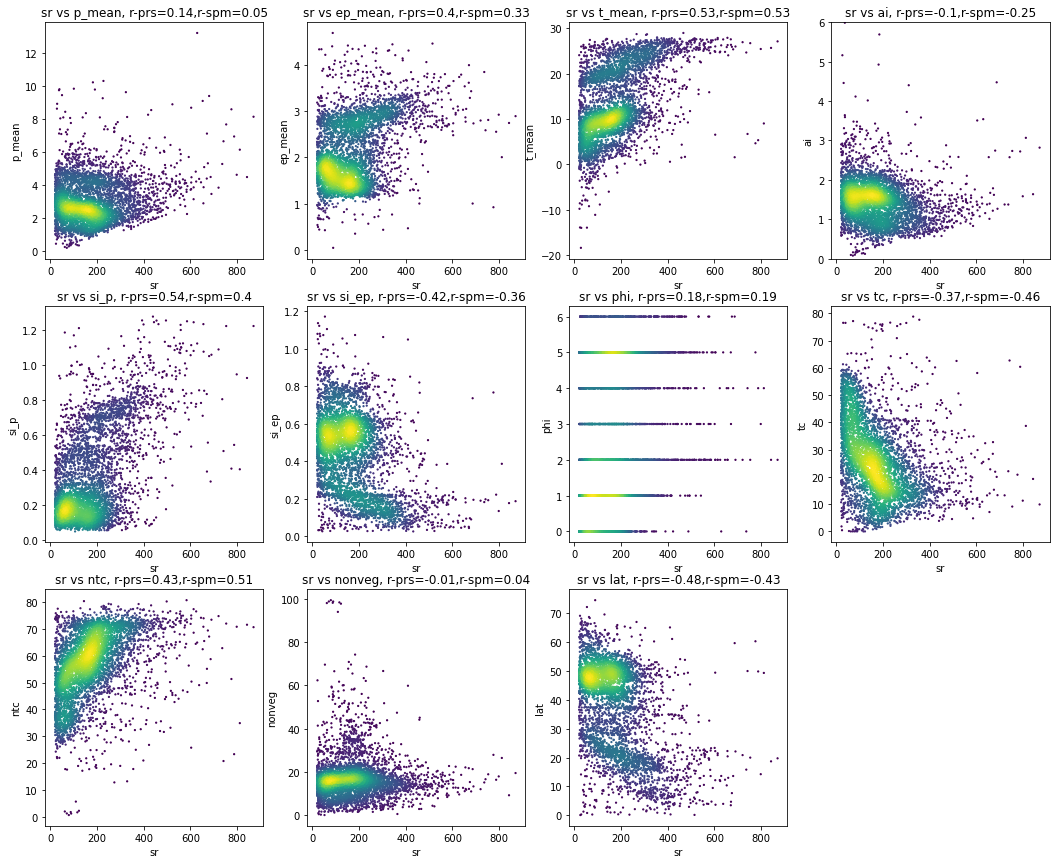

In [11]:
var = ['p_mean','ep_mean','t_mean','ai','si_p','si_ep','phi','tc','ntc','nonveg','lat']
fig = plt.figure(figsize=(18,20))
for i in range(len(var)):
    if ((var[i])=='lat'):
        c[var[i]] = abs(c[var[i]])
    
    # calculate point density
    xy = np.vstack([sr,c[var[i]]])
    z = gaussian_kde(xy)(xy)
    
    rp = np.round(np.corrcoef(sr,c[var[i]])[1,0],2)
    rp = np.round(stats.pearsonr(sr,c[var[i]])[0],2)
    rs = np.round(stats.spearmanr(sr,c[var[i]])[0],2)
    ax = fig.add_subplot(4,4,i+1)
    f = ax.scatter(sr,c[var[i]],c=z,s=1.5)
    ax.set_xlabel('sr')
    ax.set_ylabel(f'{var[i]}')
    ax.set_title(f'sr vs {var[i]}, r-prs={rp},r-spm={rs}')
    if (var[i]=='ai'):
        ax.set_ylim(0,6)
    

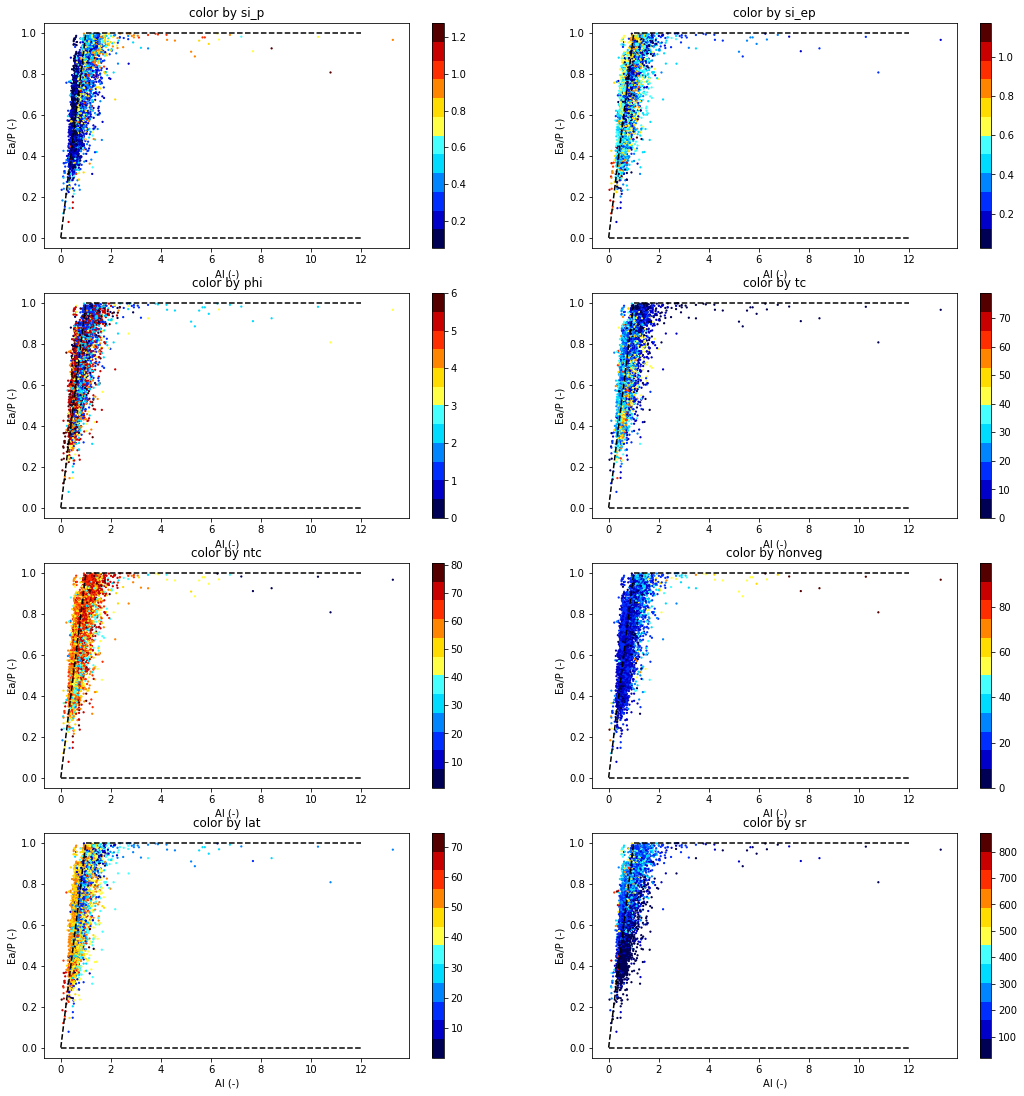

In [18]:
# use equal distribution over the AI and the EI range to visualize better (!)
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)
sr = sr_df['20']
sr = sr[sr>20]

var = ['si_p','si_ep','phi','tc','ntc','nonveg','lat','sr']
fig = plt.figure(figsize=(18,24))
x = ep/p
y = (p-q)/p
for i in range(len(var)):
    ax = fig.add_subplot(5,2,i+1)
    if (var[i]=='sr'):
        k=sr
    elif ((var[i])=='lat'):
        c[var[i]] = abs(c[var[i]])  
        k=c[var[i]]
    else:
        k=c[var[i]]
    f=ax.scatter(x,y,c=k,s=1.5,cmap=cm)
    plt.colorbar(f)
    ax.plot([0,1],[0,1], '--k')
    ax.plot([1,12],[1,1], '--k')
    ax.plot([0,12],[0,0], '--k')
    ax.set_xlabel('AI (-)')
    ax.set_ylabel('Ea/P (-)')
    ax.set_title(f'color by {var[i]}')